In [1]:
import pandas as pd
import numpy as np
import pyCLIF as pc
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings("ignore")

#from tableone import TableOne, load_dataset
con = pc.load_config()

C:\Users\vchaudha\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loaded configuration from config.json
{'site_name': 'RUSH', 'tables_path': 'C:/Users/vchaudha/Downloads/rush_parquet/', 'file_type': 'parquet'}
Loaded configuration from config.json


In [2]:
cohort = pd.read_csv('../output/intermediate/study_cohort.csv')

In [3]:
cohort.columns

Index(['patient_id', 'hospitalization_id', 'admission_dttm', 'discharge_dttm',
       'age_at_admission', 'discharge_category', 'sex_category',
       'race_category', 'ethnicity_category', 'event_time',
       'location_category', 'hospital_id', 'device_category', 'mode_category',
       'fio2_set', 'peep_set', 'resp_rate_set', 'pressure_support_set',
       'mode_name', 'device_category_bkp', 'mode_category_bkp',
       'cisatracurium', 'dobutamine', 'dopamine', 'epinephrine', 'fentanyl',
       'hydromorphone', 'midazolam', 'milrinone', 'morphine', 'norepinephrine',
       'phenylephrine', 'propofol', 'vasopressin', 'sat_delivery_pass_fail',
       'sat_screen_pass_fail', 'sbt_delivery_pass_fail',
       'sbt_screen_pass_fail', 'dbp', 'heart_rate', 'map', 'respiratory_rate',
       'sbp', 'spo2', 'weight_kg', 'date', 'day_number', 'hosp_id_day_key'],
      dtype='object')

# Eligibility Flag making

#### Device Fillforward After Waterfall

In [4]:
# List of required columns
active_vasoactive_n_col = [
    "norepinephrine", "epinephrine", "phenylephrine", "angiotensin","vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"
]

# Add missing columns with NaN values
for col in active_vasoactive_n_col:
    if col not in cohort.columns:
        cohort[col] = np.nan

# Ensure 'event_time' is in datetime format
cohort['event_time'] = pd.to_datetime(cohort['event_time'])
cohort['admission_dttm'] = pc.getdttm(cohort['admission_dttm'])
cohort['discharge_dttm'] = pc.getdttm(cohort['discharge_dttm'])

# Ensure the data is sorted by 'hosp_id_day_key' and 'event_time'
cohort = cohort.sort_values(by=['hospitalization_id', 'event_time']).reset_index(drop=True)

cohort[['device_category_w', 'mode_category_w']] = cohort[['device_category', 'mode_category']]

# #without water fall fill ward
cohort['device_category'] = cohort['device_category_bkp'].str.lower()
cohort['mode_category'] =cohort['mode_category_bkp'].str.lower()

# Fill forward the meds by hospitalization columns by 'hosp_id'
cohort[['device_category', 'mode_category', 
        'location_category']] = cohort.groupby('hospitalization_id')[
    ['device_category', 'mode_category',
     'location_category']
].ffill()

cohort[["norepinephrine", "epinephrine", "phenylephrine", "angiotensin",
    "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"]] = cohort.groupby('hospitalization_id')[
    ["norepinephrine", "epinephrine", "phenylephrine", "angiotensin",
    "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol"]
].ffill()

cohort[["fio2_set","peep_set","spo2",'pressure_support_set']] = cohort.groupby('hospitalization_id')[
    ["fio2_set","peep_set","spo2",'pressure_support_set']
].ffill()

### NEE calculation

In [5]:
cohort[['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'angiotensin', 'vasopressin']] = \
    cohort[['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'angiotensin', 'vasopressin']].fillna(0)

In [6]:
print(cohort[['norepinephrine', 'epinephrine', 'phenylephrine', 'dopamine', 'angiotensin','vasopressin']].isnull().sum())

norepinephrine    0
epinephrine       0
phenylephrine     0
dopamine          0
angiotensin       0
vasopressin       0
dtype: int64


In [7]:
cohort['NEE'] = cohort['norepinephrine'] + cohort['epinephrine'] + (cohort['phenylephrine']/10) + (cohort['vasopressin']*2.5) + (cohort['dopamine']/100) + (cohort['angiotensin']*10)

In [8]:
cohort['NEE'].describe()

count    72046.000000
mean         0.044823
std          0.168337
min          0.000000
25%          0.000000
50%          0.000000
75%          0.035212
max          3.151953
Name: NEE, dtype: float64

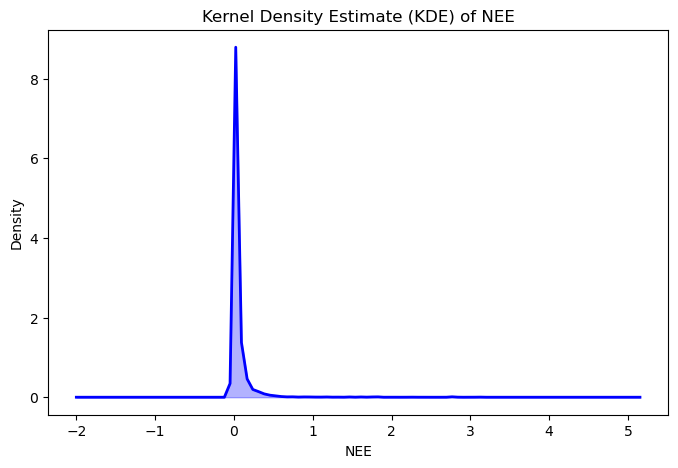

In [9]:
# Extract the "NEE" data as a numpy array.
nee_data = cohort["NEE"].values

# Compute the kernel density estimate.
kde = gaussian_kde(nee_data)

# Create a range of values where the KDE will be evaluated.
x_min, x_max = nee_data.min() - 2, nee_data.max() + 2
x_range = np.linspace(x_min, x_max, 100)

# Evaluate the KDE over the range of x values.
kde_values = kde(x_range)

# Plot the KDE using matplotlib.
plt.figure(figsize=(8, 5))
plt.plot(x_range, kde_values, color='blue', lw=2)
plt.fill_between(x_range, kde_values, alpha=0.3, color='blue')
plt.xlabel("NEE")
plt.ylabel("Density")
plt.title("Kernel Density Estimate (KDE) of NEE")
plt.show()

### Hemodynamic Stability Criteria

In [10]:
# Count the number of active vasoactive drugs per patient
cohort["active_vasoactive_count"] = (cohort[active_vasoactive_n_col] > 0).sum(axis=1)

# Define Hemodynamic Stability Flag JC
cohort["Hemodynamic_Stability_JC"] = (
    ((cohort["active_vasoactive_count"] <= 1))
).astype(int)

cohort["Hemodynamic_Stability_by_NEE"] = (
    ((cohort["NEE"] <= 0.2))
).astype(int)

# # Define Hemodynamic Stability Flag SJ
# cohort["Hemodynamic_Stability_SJ"] = (
#     (cohort["dopamine"] >= 5) |
#     (cohort["dobutamine"] >= 5) |
#     (cohort["norepinephrine"] >= 2) |
#     (cohort["vasopressin"] > 0) |
#     (cohort["milrinone"] > 0)
# ).astype(int)

In [11]:
cohort["Hemodynamic_Stability_JC"].value_counts()

Hemodynamic_Stability_JC
1    63371
0     8675
Name: count, dtype: int64

In [12]:
cohort["Hemodynamic_Stability_by_NEE"].value_counts()

Hemodynamic_Stability_by_NEE
1    68586
0     3460
Name: count, dtype: int64

In [13]:
cohort.active_vasoactive_count.value_counts()

active_vasoactive_count
0    44535
1    18836
2     6559
3     1677
4      439
Name: count, dtype: int64

In [14]:
cohort["Hemodynamic_Stability_JC"].value_counts()

Hemodynamic_Stability_JC
1    63371
0     8675
Name: count, dtype: int64

### Respiratory Stability (All conditions must be true):

In [15]:
# Define Respiratory Stability Flag
cohort["Respiratory_Stability"] = (
    (cohort["fio2_set"] <= 0.5) &
    (cohort["peep_set"] <= 8) &
    (cohort["spo2"] >= 88)
).astype(int)

In [16]:
cohort["Respiratory_Stability"].value_counts()

Respiratory_Stability
1    54800
0    17246
Name: count, dtype: int64

### IMV in a Controlled Mode for at Least 6 Hours Between 10 PM and 8 AM
With other flags as combination

In [17]:
cohort.mode_category.value_counts()

mode_category
pressure support/cpap                31659
pressure-regulated volume control    15456
pressure control                     13409
assist control-volume control         1002
simv                                   435
other                                   35
Name: count, dtype: int64

The dynamic Max window for SBT checking: [3, 4, 5, 6]


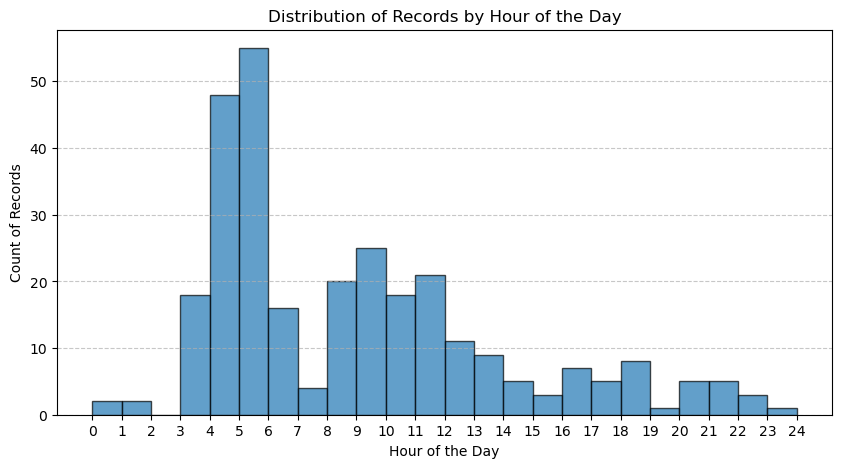

In [18]:
sbt_hrs = cohort[['event_time','sbt_delivery_pass_fail']].drop_duplicates()
sbt_hrs = sbt_hrs[sbt_hrs['sbt_delivery_pass_fail']==1]
# Assuming 'sbt_hrs' is already defined, extracting hour from 'cevent_time'
sbt_hrs['hour'] = pd.to_datetime(sbt_hrs['event_time']).dt.hour

# Calculating statistics
by_hour = pd.DataFrame(sbt_hrs['hour'].value_counts()).reset_index().sort_values('hour').reset_index(drop=True)

by_hour['rolling_sum'] = by_hour['count'].rolling(window=4).sum()
max_index = by_hour['rolling_sum'].idxmax()
max_hours = by_hour.loc[max_index-3:max_index, 'hour'].tolist()
print('The dynamic Max window for SBT checking:',max_hours)

# Plotting histogram for hour distribution
plt.figure(figsize=(10,5))
plt.hist(sbt_hrs['hour'], bins=24, range=(0,24), edgecolor='black', alpha=0.7)
plt.xticks(range(0,25,1))
plt.xlabel("Hour of the Day")
plt.ylabel("Count of Records")
plt.title("Distribution of Records by Hour of the Day")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### SBT Eligibility Criteria

In [ ]:
def process_cohort_conditions(cohort,max_hours):
    # --- Preliminary processing ---
    # Ensure event_time is datetime and sort the dataframe
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])
    cohort = cohort.sort_values(['hospitalization_id', 'event_time']).reset_index(drop=False)
    # (We keep the original index in column 'index' in case it is needed later)
    
    # # Forward-fill location_category within each hospitalization (if needed)
    # cohort['location_category_ffill'] = cohort.groupby('hospitalization_id')['location_category'].ffill()
    
    # # Precompute lowercase versions for comparisons (for condition 1)
    # cohort['device_category_lower'] = cohort['device_category'].str.lower()
    # cohort['location_category_lower'] = cohort['location_category_ffill'].str.lower()
    
    # --- Precompute Stability Flags ---
    
    # Combined stability flag (True if both are met)
    cohort['Stability_Flag'] = (cohort["Hemodynamic_Stability_by_NEE"] == 1)  
                                 # & (cohort["Respiratory_Stability"] == 1))
    cohort['IMV_flag'] = (
        (cohort['device_category'] == 'imv') &
        ((~cohort['mode_category'].str.contains('pressure support/cpap', case=False, na=False)) | ((cohort["pressure_support_set"] >= 5) & (cohort["peep_set"] >= 5))) & 
        (cohort['location_category'] == 'icu')
    )
    
    # --- Prepare new flag columns ---
    # For Condition 1 and 2, record the event_time when the threshold is reached.
    cohort['IMV_Controlled_met_time'] = pd.NaT
    cohort['Stability_met_time'] = pd.NaT
    # New flag for eligible day (1 if both conditions are met that day, else 0)
    cohort['eligible_day'] = 0
    
    # For grouping by day, use the normalized event_time (midnight)
    cohort['current_day'] = cohort['event_time'].dt.normalize()
    
    # Build a dictionary of full hospitalization data to avoid repeated filtering.
    hosp_groups = {
        hosp_id: df.copy().sort_values('event_time')
        for hosp_id, df in cohort.groupby('hospitalization_id')
    }
    
    # --- Define thresholds and time windows ---
    cond1_threshold = pd.Timedelta(hours=6)  # Condition 1: 6 cumulative hours
    cond2_threshold = pd.Timedelta(hours=1)  # Condition 2: 1 continuous hours
    
    # For Condition 1: window is 10 PM (previous day) to 8 AM (current day)
    cond1_window_start_offset = pd.Timedelta(hours=22) - pd.Timedelta(days=1)  # previous day 10 PM
    cond1_window_end_offset = pd.Timedelta(hours=8)  # current day 8 AM
    
    # For Condition 2: window is 6 AM to 5 PM (current day)
    cond2_window_start_offset = pd.Timedelta(hours=min(max_hours))
    cond2_window_end_offset = pd.Timedelta(hours=max(max_hours)+1)
    
    # --- Process each hospitalization and day ---
    # Group by hospitalization and current day
    groups = cohort.groupby(['hospitalization_id', 'current_day'])
    
    for (hosp_id, curr_day), day_group in tqdm(groups, desc="Processing each Hosp & Day"):
        # --- Condition 1: IMV in controlled mode ---
        # Define window for condition 1 based on the current day
        cond1_start = curr_day + cond1_window_start_offset
        cond1_end = curr_day + cond1_window_end_offset
        
        # Use full hospitalization data so events before midnight can contribute.
        hosp_df = hosp_groups[hosp_id]
        cond1_df = hosp_df[(hosp_df['event_time'] >= cond1_start) & (hosp_df['event_time'] <= cond1_end)].copy()
        if cond1_df.empty:
            continue  # no events in this window
        
        if not cond1_df['IMV_flag'].any():
            continue
        
        # Identify contiguous segments where IMV_flag is True.
        cond1_df['seg'] = (cond1_df['IMV_flag'] != cond1_df['IMV_flag'].shift()).cumsum()
        valid_segs = cond1_df[cond1_df['IMV_flag']].groupby('seg')
        
        cond1_met = False  # flag indicating if condition 1 was met
        for seg_id, seg_df in valid_segs:
            seg_df = seg_df.sort_values('event_time')
            seg_df['duration'] = seg_df['event_time'].diff().fillna(pd.Timedelta(seconds=0))
            seg_df['cum_duration'] = seg_df['duration'].cumsum()
            if seg_df['cum_duration'].iloc[-1] >= cond1_threshold:
                # Find the first row where the cumulative duration reaches the threshold.
                flag_row = seg_df[seg_df['cum_duration'] >= cond1_threshold].iloc[0]
                flag_idx = flag_row.name  # this is the original index in hosp_df (and cohort)
                flag_time = flag_row['event_time']
                cohort.loc[flag_idx, 'IMV_Controlled_met_time'] = flag_time
                cond1_met = True
                break  # Only the first qualifying segment for this day is flagged.
        
        # --- Condition 2: Hemodynamic & Respiratory Stability ---
        cond2_met = False  # flag for condition 2
        if cond1_met:
            cond2_start = curr_day + cond2_window_start_offset
            cond2_end = curr_day + cond2_window_end_offset
            cond2_df = day_group[(day_group['event_time'] >= cond2_start) & (day_group['event_time'] <= cond2_end)].copy()
            if not cond2_df.empty:
                cond2_df['seg'] = (cond2_df['Stability_Flag'] != cond2_df['Stability_Flag'].shift()).cumsum()
                valid_stability = cond2_df[cond2_df['Stability_Flag']].groupby('seg')
                
                for seg_id, seg_df in valid_stability:
                    seg_df = seg_df.sort_values('event_time')
                    seg_df['duration'] = seg_df['event_time'].diff().fillna(pd.Timedelta(seconds=0))
                    seg_df['cum_duration'] = seg_df['duration'].cumsum()
                    if seg_df['cum_duration'].iloc[-1] >= cond2_threshold:
                        flag_row = seg_df[seg_df['cum_duration'] >= cond2_threshold].iloc[0]
                        flag_idx = flag_row.name
                        flag_time = flag_row['event_time']
                        cohort.loc[flag_idx, 'Stability_met_time'] = flag_time
                        cond2_met = True
                        break  # Only flag the first qualifying segment for condition 2.
        
        # --- Eligible Day Flag ---
        # If both conditions are met for the day, mark all rows of this day as eligible_day = 1.
        if cond1_met and cond2_met:
            cohort.loc[day_group.index, 'eligible_day'] = 1
            
    
    return cohort

# Example usage:
final_df = process_cohort_conditions(cohort,max_hours)
# print(final_df[['hospitalization_id', 'event_time', 'IMV_Controlled_met_time', 'Stability_met_time', 'eligible_day']].head())


Processing each Hosp & Day: 100%|██████████| 2476/2476 [00:06<00:00, 360.04it/s]


In [20]:
final_df['event_time'].dtypes

dtype('<M8[ns]')

In [21]:
def process_switch_conditions(cohort):

    # Initialize columns in cohort
    cohort['flip_check_flag'] = False  
    cohort['first_flip_time'] = pd.NaT 
    # Initialize EHR Delivery columns with NaT
    ehr_minutes = [2, 5, 10, 15, 20, 30]
    for mins in ehr_minutes:
        cohort[f"EHR_Delivery_{mins}mins"] = pd.NaT

    # Ensure event_time is datetime
    cohort['event_time'] = pd.to_datetime(cohort['event_time'])

    # Filter rows where 'eligible_day' is 1 and group by hospitalization_id and current_day
    eligible_groups = cohort[cohort['eligible_day'] == 1].groupby(['hospitalization_id', 'current_day'])

    for (hosp_id, curr_day), group in tqdm(eligible_groups, desc="Processing each Hosp & Day"):
        group = group.copy()  # Ensure we modify a copy
        # Get Stability_met_time
        stability_times = group['Stability_met_time'].dropna()
        if stability_times.empty:
            continue
        T_stability = pd.to_datetime(stability_times.iloc[0])  # First non-null stability time

        # Define the condition for flip_check_flag
        mask = (
            (group['device_category'] == 'imv') &
            (group['location_category'] == 'icu') &
            (group['mode_category'].str.contains('pressure support/cpap', case=False, na=False)) &
            (group["pressure_support_set"] <= 8) &
            (group["peep_set"] <= 8) &
            (group['event_time'] >= T_stability)
        )
        # Apply the mask to update 'flip_check_flag' for this group
        group['flip_check_flag'] = mask

        # Identify the first row where flip_check_flag is True
        first_flip_idx = group.loc[mask].index.min()  # Get first row index where flip_check_flag is True

        if pd.notna(first_flip_idx):  # If there is a valid first flip
            first_flip_time = group.loc[first_flip_idx, 'event_time']  # Get event_time at first flip
            group.loc[first_flip_idx, 'first_flip_time'] = first_flip_time  # Set only for that row

            # Condition 1: Check if all Stability_Flag values are True between T_stability and first_flip_time
            # stability_condition = group[
            #     (group['event_time'] >= T_stability) &
            #     (group['event_time'] <= first_flip_time)
            # ]['Stability_Flag'].all()

            # ✅ NEW Condition 1: Median-based conditions within window T_stability to first_flip_time
            stability_window = group[
                (group['event_time'] >= T_stability) &
                (group['event_time'] <= first_flip_time)
            ]

            # Calculate medians and min NEE
            nee_max = stability_window['NEE'].max()
            # fio2_median = stability_window['fio2_set'].median()
            # peep_median = stability_window['peep_set'].median()
            # spo2_median = stability_window['spo2'].median()

            stability_condition = (
                (nee_max <= 0.2) 
                # (fio2_median <= 0.5) &
                # (peep_median <= 8) &
                # (spo2_median >= 88)
            )

            if True:
                # Loop through each time window
                for mins in ehr_minutes:
                    time_window_end = first_flip_time + pd.Timedelta(minutes=mins)

                    # Condition 2: Check if all flip_check_flag values are True in the given time window
                    flip_check_condition = group[
                        (group['event_time'] >= first_flip_time) &
                        (group['event_time'] <= time_window_end)
                    ]['flip_check_flag'].all()

                    if flip_check_condition:
                        # Find the closest row where event_time >= calculated time
                        ehr_idx = group[group['event_time'] >= time_window_end].index.min()

                        if pd.notna(ehr_idx):
                            group.loc[ehr_idx, f"EHR_Delivery_{mins}mins"] = time_window_end  # Store timestamp

        # Update the cohort dataframe with the modified group
        cohort.loc[group.index, ['flip_check_flag', 'first_flip_time'] + [f"EHR_Delivery_{mins}mins" for mins in ehr_minutes]] = \
            group[['flip_check_flag', 'first_flip_time'] + [f"EHR_Delivery_{mins}mins" for mins in ehr_minutes]]

    return cohort

In [22]:
# Then, process the switch conditions.
final_df = process_switch_conditions(final_df)

Processing each Hosp & Day: 100%|██████████| 477/477 [00:05<00:00, 92.78it/s] 


In [ ]:
final_df.head()

In [24]:
final_df.columns

Index(['index', 'patient_id', 'hospitalization_id', 'admission_dttm',
       'discharge_dttm', 'age_at_admission', 'discharge_category',
       'sex_category', 'race_category', 'ethnicity_category', 'event_time',
       'location_category', 'hospital_id', 'device_category', 'mode_category',
       'fio2_set', 'peep_set', 'resp_rate_set', 'pressure_support_set',
       'mode_name', 'device_category_bkp', 'mode_category_bkp',
       'cisatracurium', 'dobutamine', 'dopamine', 'epinephrine', 'fentanyl',
       'hydromorphone', 'midazolam', 'milrinone', 'morphine', 'norepinephrine',
       'phenylephrine', 'propofol', 'vasopressin', 'sat_delivery_pass_fail',
       'sat_screen_pass_fail', 'sbt_delivery_pass_fail',
       'sbt_screen_pass_fail', 'dbp', 'heart_rate', 'map', 'respiratory_rate',
       'sbp', 'spo2', 'weight_kg', 'date', 'day_number', 'hosp_id_day_key',
       'angiotensin', 'isoproterenol', 'device_category_w', 'mode_category_w',
       'NEE', 'active_vasoactive_count', 'Hemod

In [26]:
# final_df[[
# 'patient_id', 'hospitalization_id', 'admission_dttm','age_at_admission','hosp_id_day_key','event_time',
# 'location_category','device_category_bkp', 'mode_category_bkp','device_category','mode_category','resp_rate_set',
# 'respiratory_rate', 'fio2_set', 'peep_set','spo2','pressure_support_set','NEE',
# "norepinephrine", "epinephrine", "phenylephrine", "vasopressin", "dopamine", "dobutamine", "milrinone", "isoproterenol",
# 'sat_screen_pass_fail','sat_delivery_pass_fail','sbt_screen_pass_fail', 'sbt_delivery_pass_fail', 'flip_check_flag', 'first_flip_time','EHR_Delivery_2mins', 'EHR_Delivery_5mins',
#        'EHR_Delivery_10mins', 'EHR_Delivery_15mins', 'EHR_Delivery_20mins',
#        'EHR_Delivery_30mins','eligible_day','IMV_Controlled_met_time',
# 'Stability_met_time','Hemodynamic_Stability_JC' ,'Respiratory_Stability','Stability_Flag' , 'active_vasoactive_count'
# ]].to_csv('eflag.csv',index=False)

In [27]:
final_df.eligible_day.value_counts()

eligible_day
0    48093
1    23953
Name: count, dtype: int64

In [28]:
final_df.device_category.value_counts()

device_category
imv              29468
nasal cannula    29305
high flow nc      3945
nippv             1972
face mask         1343
other              730
trach collar       706
cpap               623
Name: count, dtype: int64

In [29]:
final_df.mode_category.value_counts()

mode_category
pressure support/cpap                31659
pressure-regulated volume control    15456
pressure control                     13409
assist control-volume control         1002
simv                                   435
other                                   35
Name: count, dtype: int64

In [30]:
unique_csns_with_eligible_day = final_df[final_df['eligible_day'] == 1]['hospitalization_id'].nunique()
total_unique_csns = final_df['hospitalization_id'].nunique()
total_eligible_days = final_df[final_df['eligible_day'] == 1]['hosp_id_day_key'].nunique()
total_days = final_df['hosp_id_day_key'].nunique()

percent_csns_with_eligible_day = (unique_csns_with_eligible_day / total_unique_csns) * 100 if total_unique_csns else 0
percent_eligible_days = (total_eligible_days / total_days) * 100 if total_days else 0

print('Unique CSNs with eligible day =>', unique_csns_with_eligible_day)
print('Total Unique CSNs =>', total_unique_csns)
print('Percentage of CSNs with eligible day => {:.2f}%'.format(percent_csns_with_eligible_day))
print('Total eligible_days =>', total_eligible_days)
print('Total days =>', total_days)
print('Percentage of eligible days => {:.2f}%'.format(percent_eligible_days))


Unique CSNs with eligible day => 145
Total Unique CSNs => 191
Percentage of CSNs with eligible day => 75.92%
Total eligible_days => 477
Total days => 2476
Percentage of eligible days => 19.26%


In [31]:
eligible_percentage = (final_df[final_df['eligible_day'] == 1]['hosp_id_day_key'].nunique() / final_df[final_df['device_category'] == 'imv'].hosp_id_day_key.nunique()) * 100
sbt_percentage = (final_df[final_df['sbt_delivery_pass_fail'] == 1].hosp_id_day_key.nunique() / 
                  final_df[final_df['device_category'] == 'imv'].hosp_id_day_key.nunique()) * 100

print(f"Percentage of hospital days eligible out of total ventilated days: {eligible_percentage:.2f}%")
print(f"Percentage of hospital days with SBT performed out of total ventilated days: {sbt_percentage:.2f}%")


Percentage of hospital days eligible out of total ventilated days: 61.87%
Percentage of hospital days with SBT performed out of total ventilated days: 33.07%


In [32]:
# Extract year
final_df['year'] = final_df['event_time'].dt.year

# Group by year and calculate percentages safely
def calculate_yearly_stats(df):
    total_imv = df[df['device_category'] == 'imv']['hosp_id_day_key'].nunique()
    
    if total_imv == 0:
        return pd.Series({'eligible_percentage': 0, 'sbt_percentage': 0})  # Avoid division by zero
    
    eligible_days = df[df['eligible_day'] == 1]['hosp_id_day_key'].nunique()
    sbt_days = df[df['sbt_delivery_pass_fail'] == 1]['hosp_id_day_key'].nunique()
    
    eligible_percentage = (eligible_days / total_imv) * 100
    sbt_percentage = (sbt_days / total_imv) * 100
    
    return pd.Series({'eligible_percentage': eligible_percentage, 'sbt_percentage': sbt_percentage})

# Apply function to each year
yearly_stats = final_df.groupby('year').apply(calculate_yearly_stats).reset_index()
yearly_stats

,year,eligible_percentage,sbt_percentage
0,2025,61.867704,33.07393


In [33]:
def calculate_yearly_flag_success(df):
    # Extract year from event_time
    df['year'] = df['admission_dttm'].dt.year

    # Columns to compute percentages
    columns_to_check = [
        'sat_screen_pass_fail', 'sat_delivery_pass_fail', 'sbt_screen_pass_fail', 
        'sbt_delivery_pass_fail','eligible_day', 'EHR_Delivery_2mins', 'EHR_Delivery_5mins',
        'EHR_Delivery_10mins', 'EHR_Delivery_15mins', 'EHR_Delivery_20mins',
        'EHR_Delivery_30mins'
    ]

    # Function to calculate yearly success percentages
    def yearly_stats(df_year):
        total_imv = df_year[df_year['device_category'] == 'imv']['hosp_id_day_key'].nunique()

        if total_imv == 0:
            return pd.Series({col: 0 for col in columns_to_check})  # Avoid division by zero

        flag_percentages = {
            col: (df_year[df_year[col].notna()]['hosp_id_day_key'].nunique() / total_imv) * 100
            for col in columns_to_check
        }

        return pd.Series(flag_percentages)

    # Apply function to each year
    yearly_success_rates = df.groupby('year').apply(yearly_stats).reset_index()

    return yearly_success_rates

# Process user-uploaded DataFrame
yearly_success_rates_df = calculate_yearly_flag_success(final_df)
yearly_success_rates_df


,year,sat_screen_pass_fail,sat_delivery_pass_fail,sbt_screen_pass_fail,sbt_delivery_pass_fail,eligible_day,EHR_Delivery_2mins,EHR_Delivery_5mins,EHR_Delivery_10mins,EHR_Delivery_15mins,EHR_Delivery_20mins,EHR_Delivery_30mins
0,2025,22.049287,17.380026,40.466926,33.07393,321.141375,24.773022,23.476005,21.919585,21.789883,21.400778,20.233463


In [34]:
# Ensure the specified columns are treated as datetime before calculating percentages
datetime_columns = [
    'EHR_Delivery_2mins', 'EHR_Delivery_5mins', 'EHR_Delivery_10mins',
    'EHR_Delivery_15mins', 'EHR_Delivery_20mins', 'EHR_Delivery_30mins'
]

for col in datetime_columns:
    if col in final_df.columns:
        final_df[col] = final_df[col].notna().astype(int)


In [35]:

# List of columns to check
columns_to_check = [ 
    'sat_screen_pass_fail', 'sat_delivery_pass_fail', 'sbt_screen_pass_fail', 
    'sbt_delivery_pass_fail', 'eligible_day', 'EHR_Delivery_2mins', 'EHR_Delivery_5mins',
    'EHR_Delivery_10mins', 'EHR_Delivery_15mins', 'EHR_Delivery_20mins',
    'EHR_Delivery_30mins'
]

# Calculate percentages for each column in columns_to_check
percentages = {}
total_ventilated_days = final_df[ (final_df['eligible_day'] == 1)].hosp_id_day_key.nunique()

for col in columns_to_check:
    if col in final_df.columns:
        percentages[col] = (final_df[final_df[col] == 1].hosp_id_day_key.nunique() / total_ventilated_days) * 100

# Display the results
for col, percentage in percentages.items():
    print(f"% of hospital days with {col} out of total eligible_day: {percentage:.2f}%")

% of hospital days with sat_screen_pass_fail out of total eligible_day: 35.64%
% of hospital days with sat_delivery_pass_fail out of total eligible_day: 28.09%
% of hospital days with sbt_screen_pass_fail out of total eligible_day: 65.41%
% of hospital days with sbt_delivery_pass_fail out of total eligible_day: 53.46%
% of hospital days with eligible_day out of total eligible_day: 100.00%
% of hospital days with EHR_Delivery_2mins out of total eligible_day: 40.04%
% of hospital days with EHR_Delivery_5mins out of total eligible_day: 37.95%
% of hospital days with EHR_Delivery_10mins out of total eligible_day: 35.43%
% of hospital days with EHR_Delivery_15mins out of total eligible_day: 35.22%
% of hospital days with EHR_Delivery_20mins out of total eligible_day: 34.59%
% of hospital days with EHR_Delivery_30mins out of total eligible_day: 32.70%


In [36]:
# List of columns to check
columns_to_check = [ 
    'sat_screen_pass_fail', 'sat_delivery_pass_fail', 'sbt_screen_pass_fail', 
    'sbt_delivery_pass_fail', 'eligible_day', 'EHR_Delivery_2mins', 'EHR_Delivery_5mins',
    'EHR_Delivery_10mins', 'EHR_Delivery_15mins', 'EHR_Delivery_20mins',
    'EHR_Delivery_30mins'
]

# Calculate percentages for each column in columns_to_check
percentages = {}
total_ventilated_days = final_df[ (final_df['device_category'] == 'imv')].hosp_id_day_key.nunique()

for col in columns_to_check:
    if col in final_df.columns:
        percentages[col] = (final_df[final_df[col] == 1].hosp_id_day_key.nunique() / total_ventilated_days) * 100

# Display the results
for col, percentage in percentages.items():
    print(f"% of hospital days with {col} out of total vent days: {percentage:.2f}%")

% of hospital days with sat_screen_pass_fail out of total vent days: 22.05%
% of hospital days with sat_delivery_pass_fail out of total vent days: 17.38%
% of hospital days with sbt_screen_pass_fail out of total vent days: 40.47%
% of hospital days with sbt_delivery_pass_fail out of total vent days: 33.07%
% of hospital days with eligible_day out of total vent days: 61.87%
% of hospital days with EHR_Delivery_2mins out of total vent days: 24.77%
% of hospital days with EHR_Delivery_5mins out of total vent days: 23.48%
% of hospital days with EHR_Delivery_10mins out of total vent days: 21.92%
% of hospital days with EHR_Delivery_15mins out of total vent days: 21.79%
% of hospital days with EHR_Delivery_20mins out of total vent days: 21.40%
% of hospital days with EHR_Delivery_30mins out of total vent days: 20.23%


In [37]:
percentages

{'sat_screen_pass_fail': 22.04928664072633,
 'sat_delivery_pass_fail': 17.380025940337223,
 'sbt_screen_pass_fail': 40.46692607003891,
 'sbt_delivery_pass_fail': 33.07392996108949,
 'eligible_day': 61.86770428015564,
 'EHR_Delivery_2mins': 24.77302204928664,
 'EHR_Delivery_5mins': 23.476005188067443,
 'EHR_Delivery_10mins': 21.91958495460441,
 'EHR_Delivery_15mins': 21.78988326848249,
 'EHR_Delivery_20mins': 21.40077821011673,
 'EHR_Delivery_30mins': 20.233463035019454}

In [38]:
final_df[(final_df['device_category'] == 'imv') & (final_df['eligible_day'] == 1)].hosp_id_day_key.nunique()

477

In [39]:
final_df[(final_df['EHR_Delivery_15mins'] == 1) ].hosp_id_day_key.nunique()

168

In [40]:
final_df['eligible_day'].value_counts()

eligible_day
0    48093
1    23953
Name: count, dtype: int64